# MPC Example Using Scipy optimization
reference: 

https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html

To Do:

Create NL model; create function to simulate response to input; 


In [1]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import LinearConstraint
%matplotlib inline

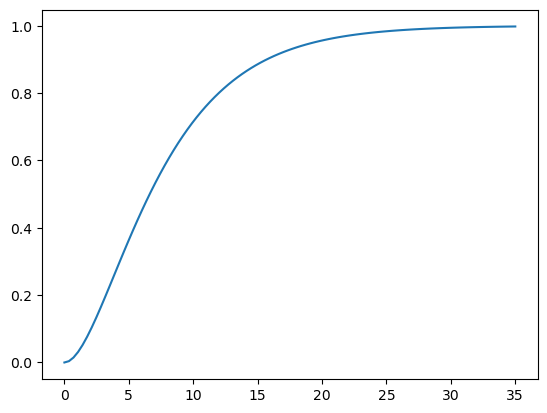

In [2]:
G = scipy.signal.lti([1], [15, 8, 1])
plt.plot(*G.step());

In [3]:
M = 10  # Control horizon
P = 100  # Prediction horizon
DeltaT = .1  # Sampling rate
tcontinuous = np.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = np.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

# first order reference trajectory
tau_c = 1
r = 1 - np.exp(-tpredict/tau_c)  

u = np.ones(M)  # initial guess for optimized control

x0 = np.zeros(G.to_ss().A.shape[0])  # Initial system state

In [4]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

In [5]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

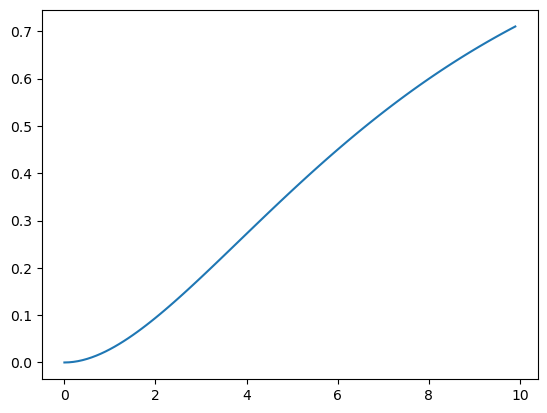

In [6]:
plt.plot(tpredict, prediction(extend(u)));


In [7]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(np.abs(np.diff(u)))
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.0*movepenalty + 0*strongfinish

In [8]:
objective(u)

32.94191787624925

In [9]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

0.02948126435150734

In [10]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]


In [11]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.grid()
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.grid()
    plt.legend()

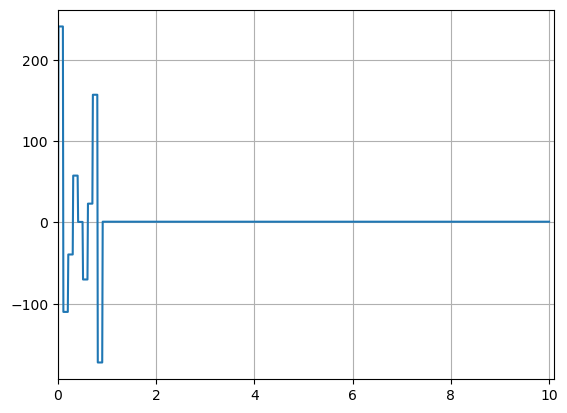

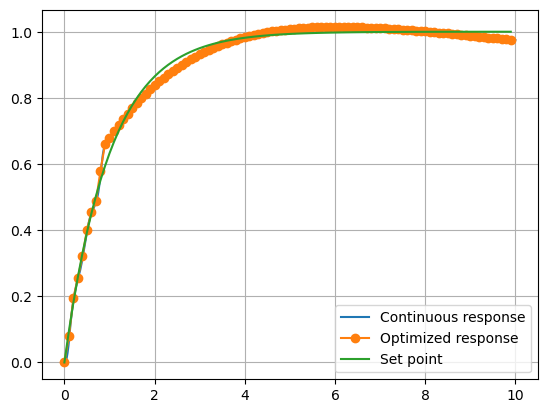

In [12]:
plotoutput(ucont, uopt)

### Simple NL MPC Model

Stable continuous nonlinear model: <br /> 
$\dot{x} = -x^{3} + u$

In discrete time using finite difference: <br /> 
$x[k+1] = x[k] - \Delta T x[k]^{3} + \Delta T u[k]$

Steady state output:  1.2485555011266727


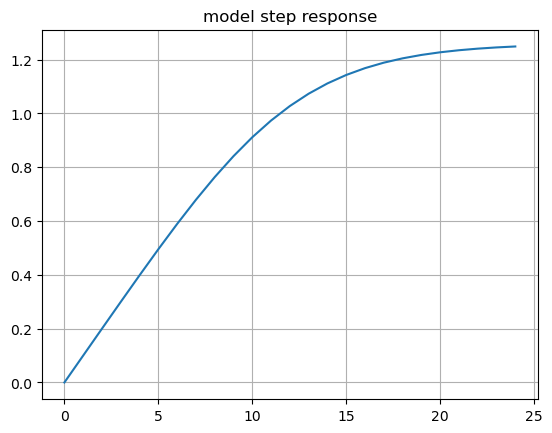

In [65]:
x = np.zeros(25)
u = 2*np.ones(25)
dt = 0.05
for k in range(len(x)-1):
    x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
plt.plot(x)
plt.title("model step response")
plt.grid()
print("Steady state output: ", x[-1])

In [66]:
def nl_prediction(u, dt, x0=x0):
    """Predict the effect of an input signal"""
    x = np.empty(len(u))    
    x[0] = x0
    for k in range(len(x)-1):
        x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
    return x

In [67]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the control problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = nl_prediction(extend(u), dt, x0)    
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])    
    #movepenalty = sum(np.abs(np.diff(u)))
    movepenalty = sum(np.diff(u)**2)
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.0*movepenalty + 0*strongfinish

In [68]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

In [86]:
# plot results
def plot_results(timeSamples, x, ref, u):    
    plt.figure()
    plt.plot(timeSamples, x, '-bo', label = 'Output')
    plt.plot(timeSamples, ref[:len(timeSamples)], 'r', label='Reference')
    plt.grid()
    plt.legend()    
    plt.figure()
    plt.plot(timeSamples, u, label='Control')
    plt.grid()
    plt.legend()
    plt.figure()
    plt.plot(timeSamples[0:-1], np.diff(u, axis=0), label='$\Delta$ Control')
    plt.grid()
    plt.legend()


In [97]:
M = 25
P = 50

# first order reference trajectory
tau_c = 1
tpredict = np.arange(0, P*dt, dt)   # discrete points at prediction horizon
r = 2 - 2*np.exp(-tpredict/tau_c)  
u = np.zeros(M)  # initial guess for optimized control


In [112]:
def linear_constraint_calc(M, lb, ub):
    A= -np.eye(M)+np.eye(M, k=1)
    return LinearConstraint(A, lb*np.ones((M,)), ub*np.ones((M,)))

0.11099958419799805
26.980170010782032


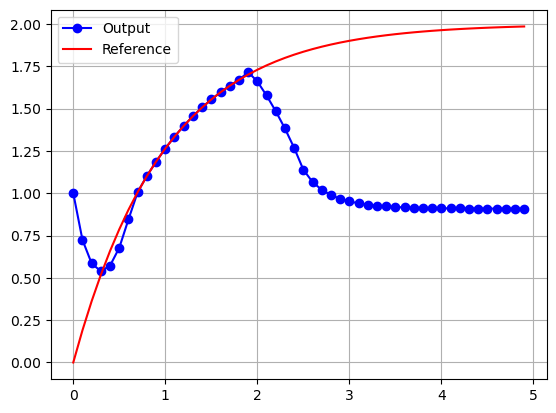

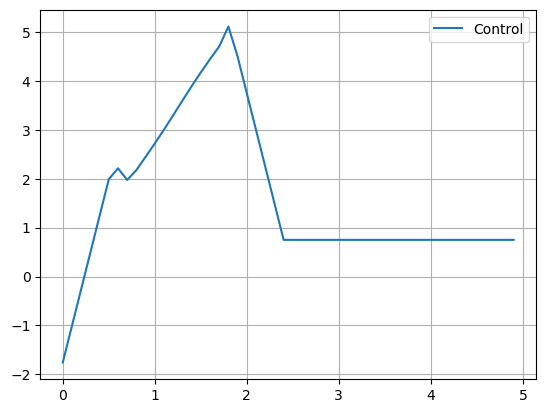

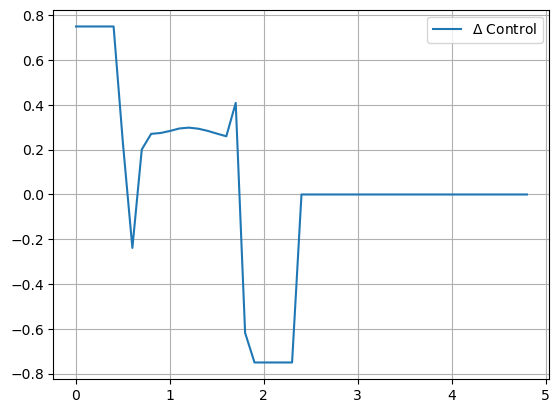

In [101]:
x0 = 0
startTime = time()
linear_constraint = linear_constraint_calc(M)
result = scipy.optimize.minimize(objective, u, method = 'SLSQP', constraints=[linear_constraint])
#result = scipy.optimize.minimize(objective, u, x0)
print(time()-startTime)
uopt = result.x
print(result.fun)
uact = extend(uopt)
plot_results(tpredict, nl_prediction(uact, dt), r, uact)

## Simulate control loop 

In [113]:
# Set initial conditions and tuning parameters
M = 75
P = 100
simTime = 50
dt = 0.1
cycles = int(simTime/dt)
x = np.zeros((cycles, 1))
uact = np.ones((cycles, 1))

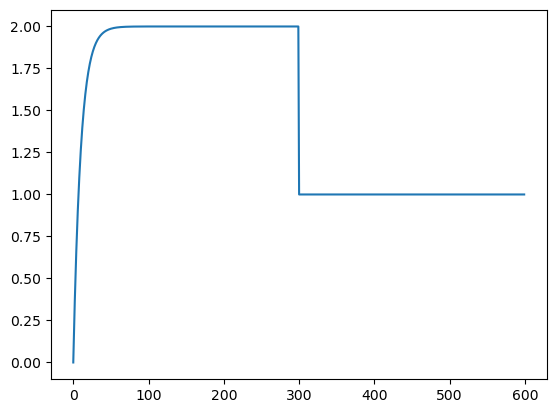

In [114]:
#set reference trajectory
tau_c = 1
t1 = np.arange(0, P*dt, dt)
ref1 = 2 - 2*np.exp(-t1/tau_c)  
ref2 = np.repeat(ref1[-1], 200)
ref3 = np.repeat(1, 300)
ref4 = np.repeat(-1, P+cycles-len(ref1)-len(ref2)-len(ref3))
ref = np.concatenate([ref1, ref2, ref3, ref4])
plt.plot(ref);

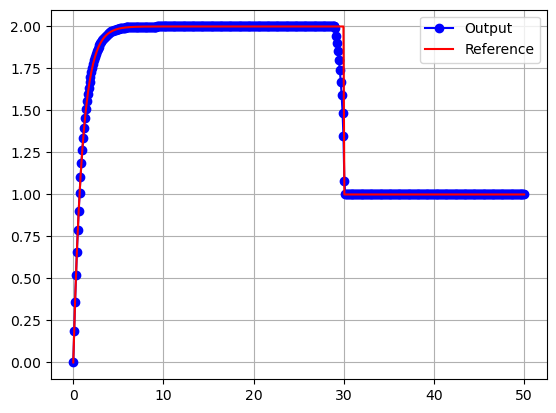

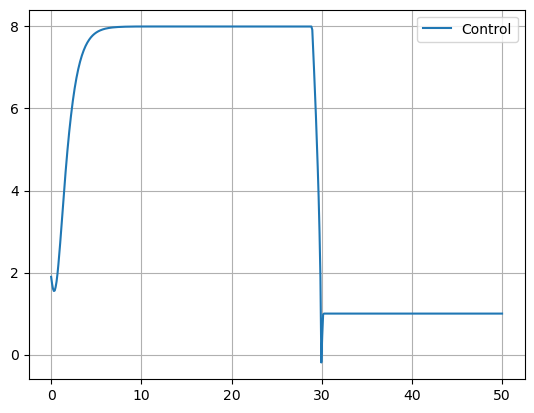

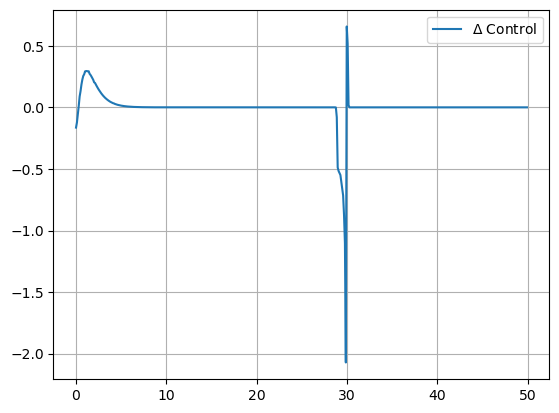

In [116]:
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
# simulation loop
u = np.ones(M)  # optimization initial guess

ub = 0.5
lb = -0.5 
linear_constraint = linear_constraint_calc(M, lb, ub)
for k in range(cycles-1):
    r = ref[k:k+P]
    x0 = x[k]
    # call optimization    
    #result = scipy.optimize.minimize(objective, u, x0)
    result = scipy.optimize.minimize(objective, u, x0, method = 'SLSQP', constraints=[linear_constraint])
    uopt = result.x    
    uact[k] = uopt[0]
    
    # simulate plant with control input
    x[k+1] = x[k] -dt*x[k]**3 + dt*uact[k]
    
    u = uact[k]*np.ones(M)  # update optimization guess for the next iteration
    
    if np.abs(x[k]) > 1E6:
        break
        
# plot results
timeSamples = np.linspace(0, simTime, len(x))
plot_results(timeSamples, x, ref, uact)

In [111]:
uact[1:]-uact[0:-1]

array([[ 1.49186928e-01],
       [ 1.67156286e-01],
       [ 1.87107919e-01],
       [ 2.05618437e-01],
       [ 2.20958084e-01],
       [ 2.30601533e-01],
       [ 2.34869978e-01],
       [ 2.34530989e-01],
       [ 2.30121684e-01],
       [ 2.04743629e-01],
       [ 2.00000000e-01],
       [ 2.06118902e-01],
       [ 2.01431170e-01],
       [ 1.92449928e-01],
       [ 2.00000000e-01],
       [ 1.95173623e-01],
       [ 1.68801487e-01],
       [ 1.60970774e-01],
       [ 1.56976436e-01],
       [ 1.49599219e-01],
       [ 1.60188131e-01],
       [ 1.36278591e-01],
       [ 1.32462593e-01],
       [ 1.34087336e-01],
       [ 1.20906917e-01],
       [ 1.16887712e-01],
       [ 1.10448456e-01],
       [ 9.76768105e-02],
       [ 1.14293284e-01],
       [ 1.00741941e-01],
       [ 9.48217879e-02],
       [ 8.56021493e-02],
       [ 6.28250674e-02],
       [ 8.40774827e-02],
       [ 6.42727378e-02],
       [ 5.96795285e-02],
       [ 9.72809270e-04],
       [ 8.23016613e-02],
       [ 1.1